# Word tagging exercice


In [1]:
from __future__ import print_function

import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))


Using TensorFlow backend.


## Data

In [2]:
import numpy as np 

import pickle

atis_file = '/home/ubuntu/data/training/text/atis/atis.pkl'
with open(atis_file,'rb') as f:
    #train, test, dicts = pickle.load(f, encoding='bytes')
    train, test, dicts = pickle.load(f)


In [3]:
print(dicts.keys())

['labels2idx', 'tables2idx', 'words2idx']


## train / test sets:
    - X: list of sequences
    - ne: PENDING
    - label: name entities
## Dictionaries
    - labels2idx
    - words2idx

In [5]:
# Visualize data

#w2idx, ne2idx, labels2idx = dicts['words2idx'], dicts['tables2idx'], dicts['labels2idx']
#idx2w  = dict((v,k) for k,v in w2idx.iteritems())
#idx2ne = dict((v,k) for k,v in ne2idx.iteritems())
#idx2la = dict((v,k) for k,v in labels2idx.iteritems())


w2idx, ne2idx, labels2idx = dicts[b'words2idx'], dicts[b'tables2idx'], dicts[b'labels2idx']
    
idx2w  = dict((v,k) for k,v in w2idx.items())
idx2ne = dict((v,k) for k,v in ne2idx.items())
idx2la = dict((v,k) for k,v in labels2idx.items())

train_x, train_ne, train_label = train
test_x,  test_ne,  test_label  = test
wlength = 35

for e in ['train','test']:
    print(e)
    for sw, se, sl in zip(eval(e+'_x')[:5], eval(e+'_ne')[:5], eval(e+'_label')[:10]):
        print( 'WORD'.rjust(wlength), 'LABEL'.rjust(wlength))
        for wx, la in zip(sw, sl): print( idx2w[wx].rjust(wlength), idx2la[la].rjust(wlength))
        print( '\n'+'**'*30+'\n')


train
                               WORD                               LABEL
                                  i                                   O
                               want                                   O
                                 to                                   O
                                fly                                   O
                               from                                   O
                             boston                 B-fromloc.city_name
                                 at                                   O
                    DIGITDIGITDIGIT                  B-depart_time.time
                                 am                  I-depart_time.time
                                and                                   O
                             arrive                                   O
                                 in                                   O
                             denver                   B-to

# Model

For each word in the sentence, predict the label

First, for each word in each sentence, generate  the context with the previous and next words in the sentence.
This create a train dataset of num_sentences*

In [6]:
def context(l, size=3):
    l = list(l)
    lpadded = size // 2 * [572] + l + size // 2 * [572]
    out = [lpadded[i:(i + size)] for i in range(len(l))]
    return out

x = np.array([0, 1, 2, 3, 4], dtype=np.int32)
context(x)

[[572, 0, 1], [0, 1, 2], [1, 2, 3], [2, 3, 4], [3, 4, 572]]

In [8]:
X_trn=[]
for s in train_x:
    X_trn += context(s,size=10)
X_trn = np.array(X_trn)

X_tst=[]
for s in test_x:
    X_tst += context(s,size=10)
X_tst = np.array(X_tst)

print(X_trn.shape, X_tst.shape)

(56590, 10) (9198, 10)


In [9]:
y_trn=[]
for s in train_label:
    y_trn += list(s)
y_trn = np.array(y_trn)
print(y_trn.shape)

y_tst=[]
for s in test_label:
    y_tst += list(s)
y_tst = np.array(y_tst)
print(y_tst.shape)

(56590,)
(9198,)


In [10]:
print(len(set(y_trn)))
print(len(set(idx2w)))

121
572


In [11]:
#Model parameters

input_seq_length = X_trn.shape[1]
input_vocabulary_size = len(set(idx2w)) + 1
output_length = 127
num_hidden_lstm = 128

In [12]:
# build the model: Simple LSTM with embedings
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, Embedding

print('Build model 1')
seq_input = Input(shape=([input_seq_length]), name='prev') 
    
embeds = Embedding(input_vocabulary_size, 64)(seq_input)
    
# apply forwards LSTM
#forwards1 = LSTM(512, dropout_W=0.3, dropout_U=0.3, return_sequences=True)(embed)

forwards = LSTM(num_hidden_lstm, return_sequences=False)(embeds)

output = Dense(output_length, activation='softmax')(forwards)

model1 = Model(input=seq_input, output=output)
model1.summary()

# Optimizer
model1.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Build model 1
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
prev (InputLayer)                (None, 10)            0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 10, 64)        36672       prev[0][0]                       
____________________________________________________________________________________________________
lstm_1 (LSTM)                    (None, 128)           98816       embedding_1[0][0]                
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 127)           16383       lstm_1[0][0]                     
Total params: 151871
________________________________________________________

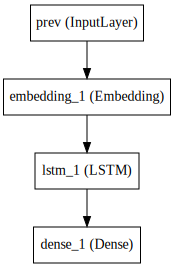

In [13]:
#Plot the model graph
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(model1).create(prog='dot', format='svg'))

In [14]:
#Fit model
history = model1.fit(X_trn, y_trn, batch_size=128, nb_epoch=10,
           validation_data=(X_tst, y_tst))


Train on 56590 samples, validate on 9198 samples
Epoch 1/10
56590/56590 [==============================] - 19s - loss: 1.5004 - acc: 0.6934 - val_loss: 0.9554 - val_acc: 0.7648
Epoch 2/10
56590/56590 [==============================] - 19s - loss: 0.5813 - acc: 0.8644 - val_loss: 0.4528 - val_acc: 0.9033
Epoch 3/10
56590/56590 [==============================] - 19s - loss: 0.2789 - acc: 0.9392 - val_loss: 0.3014 - val_acc: 0.9357
Epoch 4/10
56590/56590 [==============================] - 19s - loss: 0.1744 - acc: 0.9612 - val_loss: 0.2381 - val_acc: 0.9481
Epoch 5/10
56590/56590 [==============================] - 19s - loss: 0.1210 - acc: 0.9736 - val_loss: 0.2257 - val_acc: 0.9559
Epoch 6/10
56590/56590 [==============================] - 19s - loss: 0.0907 - acc: 0.9797 - val_loss: 0.1876 - val_acc: 0.9630
Epoch 7/10
56590/56590 [==============================] - 19s - loss: 0.0735 - acc: 0.9834 - val_loss: 0.1928 - val_acc: 0.9626
Epoch 8/10
56590/56590 [==============================]

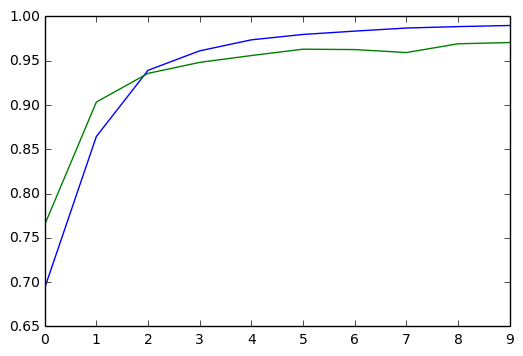

In [15]:
#Plot graphs in the notebook output
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.show()

In [16]:
# build the model: Bidirectional LSTM with embedings
from keras.models import Model
from keras.layers import Input, Dense, Dropout, LSTM, Embedding, Merge, Bidirectional

print('Build model 2')
seq_input = Input(shape=([input_seq_length]), name='prev') 
    
embeds = Embedding(input_vocabulary_size, 64)(seq_input)
    
# Bidirectional wrapper
rnn_out = Bidirectional(LSTM(num_hidden_lstm))(embeds)

output = Dense(output_length, activation='softmax')(rnn_out)

model2 = Model(input=seq_input, output=output)
model2.summary()

# Optimizer
model2.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


Build model 2
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
prev (InputLayer)                (None, 10)            0                                            
____________________________________________________________________________________________________
embedding_2 (Embedding)          (None, 10, 64)        36672       prev[0][0]                       
____________________________________________________________________________________________________
bidirectional_1 (Bidirectional)  (None, 256)           197632      embedding_2[0][0]                
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 127)           32639       bidirectional_1[0][0]            
Total params: 266943
________________________________________________________

In [ ]:
SVG(model_to_dot(model2).create(prog='dot', format='svg'))

In [17]:
#Fit model
history2 = model2.fit(X_trn, y_trn, batch_size=128, nb_epoch=10,
           validation_data=(X_tst, y_tst))


Train on 56590 samples, validate on 9198 samples
Epoch 1/10
56590/56590 [==============================] - 35s - loss: 1.3485 - acc: 0.7166 - val_loss: 0.7889 - val_acc: 0.8124
Epoch 2/10
56590/56590 [==============================] - 35s - loss: 0.4338 - acc: 0.8907 - val_loss: 0.3672 - val_acc: 0.9127
Epoch 3/10
56590/56590 [==============================] - 35s - loss: 0.1900 - acc: 0.9544 - val_loss: 0.2221 - val_acc: 0.9522
Epoch 4/10
56590/56590 [==============================] - 35s - loss: 0.1129 - acc: 0.9736 - val_loss: 0.2094 - val_acc: 0.9572
Epoch 5/10
56590/56590 [==============================] - 35s - loss: 0.0805 - acc: 0.9808 - val_loss: 0.1971 - val_acc: 0.9573
Epoch 6/10
56590/56590 [==============================] - 34s - loss: 0.0598 - acc: 0.9852 - val_loss: 0.1719 - val_acc: 0.9662
Epoch 7/10
56590/56590 [==============================] - 35s - loss: 0.0488 - acc: 0.9873 - val_loss: 0.1666 - val_acc: 0.9679
Epoch 8/10
56590/56590 [==============================]

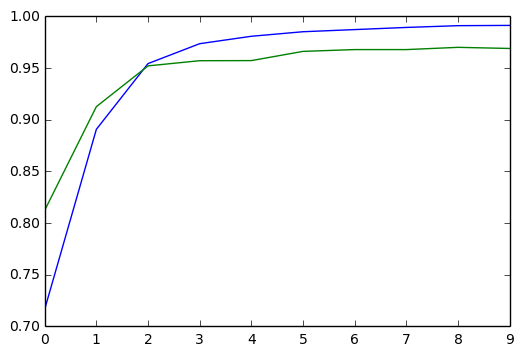

In [18]:
#Plot graphs in the notebook output
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(history2.history['acc'])
plt.plot(history2.history['val_acc'])
plt.show()